## Clasificador de Noticias Argentinas 

In [66]:
import pandas as pd

df = pd.read_excel('../../res/tp1/Noticias_argentinas.xlsx', sheet_name='aa_bayes')

In [67]:
# Nos quedamos con los atributos de interes

df = df[["titular", "categoria"]]

# removemos las categorias que no necesitamos ('Destacadas', 'Noticias Destacadas')


df.head()

,titular,categoria
0,Trabajadores del Buenos Aires Design cortan la...,Nacional
1,La boda del gobernador Gerardo Morales: tapas ...,Nacional
2,Cumbre del G20: qué calles estarán cortadas y ...,Nacional
3,Una fractura que confirma la candidatura de Cr...,Nacional
4,Infierno grande: ola de divorcios en un pueblo...,Nacional


In [68]:
df = df.loc[df['categoria'].isin(("Nacional", "Economia", "Internacional", "Deportes", "Salud", "Ciencia y Tecnologia", "Entretenimiento"))]
df.head()
categories = df['categoria'].unique()
print(categories)


['Nacional' 'Deportes' 'Salud' 'Ciencia y Tecnologia' 'Entretenimiento'
 'Economia' 'Internacional']


In [69]:
df['categoria'].value_counts()

Nacional                3860
Ciencia y Tecnologia    3856
Deportes                3855
Internacional           3850
Entretenimiento         3850
Economia                3850
Salud                   3840
Name: categoria, dtype: int64

In [70]:
from sklearn.model_selection import train_test_split

# Separar los datos en datos de entrenamiento y testeo
train, test = train_test_split(df, test_size=0.2)
train.head()
test.head()

,titular,categoria
6818,Investigan la muerte de un militante ligado a ...,Nacional
26264,Superliga | San Lorenzo no supo cómo aguantar ...,Deportes
28153,Uruguay rechazó otorgar asilo a Alan García,Internacional
2974,Juez amparó asilo a migrantes,Internacional
2867,El desesperado pedido de Benjamín Vicuña despu...,Entretenimiento


In [71]:
textos = list(df['titular'])

In [72]:
# Crear diccionario de categorias con diccionarios vacios para las palabras de los titulares
categories_word_appearances = { i : {} for i in categories }

In [73]:
import re

def split_and_sanitize(title):
    words = title.split()  # se separan las palabras según espacios (quita todos los espacios)
    words = list(map(lambda x: re.sub("[^\w\s]", '', x), words))  # reemplazo de símbolos por ningún caracter
    return words

for i in range(len(train)):
    row = train.iloc[i]
    category = row['categoria']
    title = row['titular']
    words = split_and_sanitize(title)
    
    for word in words:
            if word in categories_word_appearances[category]:
                categories_word_appearances[category][word] += 1
            else:
                categories_word_appearances[category][word] = 1
                
    
    
    

In [74]:
print(categories_word_appearances['Entretenimiento']['Pampita'])

68


In [75]:
# Calcular probabilidades de las clases P(category) para el conjunto de entrenamiento

category_relative_freq = train['categoria'].value_counts() / len(train)  # P(category)
print(category_relative_freq)

# Calcular las probabilidades condicionales P(word | category)
word_relative_frequencies = { i : {} for i in categories }
zero_probabilities = { i : 0 for i in categories } # Laplace correction in case a word does not appear in a category
for category in categories:
    word_appearances_sum = sum(categories_word_appearances[category].values())
    laplace_denominator = float(word_appearances_sum + len(categories_word_appearances[category].keys()))
    zero_probabilities[category] = 1 / laplace_denominator
    for word, word_count in categories_word_appearances[category].items():
        word_relative_frequencies[category][word] = (word_count + 1) / laplace_denominator

print(word_relative_frequencies['Entretenimiento']['Pampita'])
print(sum(word_relative_frequencies['Entretenimiento'].values()))
# Objetivo final:
#   P (category | [word])
# = P ([word] | category) * P (category)      ##  / P ([word])
# = prod(P (word | category)) * P (category)

Deportes                0.145401
Ciencia y Tecnologia    0.143685
Economia                0.142897
Internacional           0.142665
Nacional                0.142665
Entretenimiento         0.142201
Salud                   0.140486
Name: categoria, dtype: float64
0.0014827867795590322
0.999999999999989


In [76]:
def classify(title):
    words = split_and_sanitize(title)
    vs = {}
    for category in categories:
        v = category_relative_freq.loc[category]
        for word in words:
            if word in word_relative_frequencies[category]:
                v *= word_relative_frequencies[category][word]
            else:
                v *= zero_probabilities[category]
        vs[category] = v
        #print(v)
    mx = (None, 0)
    for category, v in vs.items():
        if v > mx[1]:
            mx = (category, v)
    return mx[0]

noticia = 'Pampita fue a la mesa de Mirtha'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")
noticia = 'Messi metió un gol'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")
noticia = 'Apple lanzó un nuevo iPhone'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")

La noticia 'Pampita fue a la mesa de Mirtha' pertenece a Entretenimiento
La noticia 'Messi metió un gol' pertenece a Deportes
La noticia 'Apple lanzó un nuevo iPhone' pertenece a Ciencia y Tecnologia


<AxesSubplot:>

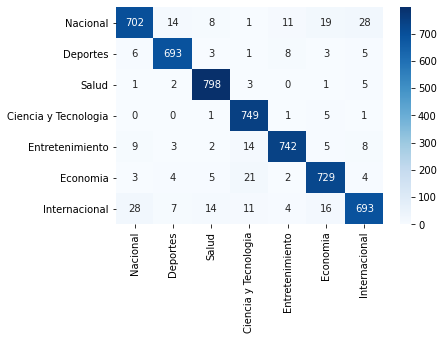

In [77]:
confusion_matrix = { i : {} for i in categories }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { i : 0 for i in categories } # {'Deportes': {'Deportes': 700, 'Entretenimiento': 3, ...}, ...}

for i in range(len(test)):
    row = test.iloc[i]
    category = row['categoria']
    title = row['titular']
    result = classify(title)
    confusion_matrix[category][result] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

import seaborn as sns
sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g')

In [78]:
import numpy as np

true = []
predicted = []

for i in range(len(test)):
    row = test.iloc[i]
    true.append(row['categoria'])
    title = row['titular']
    predicted.append(classify(title))

    
# Calculamos las metricas para cada categoria    
    
category_metrics = { i : {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'accuracy': 0, 'precision': 0, 'recall': 0,  'f1': 0} for i in categories }

for i, category in enumerate(categories):
    
    # Metricas simples
    tp = confusion_df.iloc[i,i]
    tn = sum(np.diag(confusion_df)) - tp
    fn = sum(confusion_df.loc[category]) - tp
    fp = sum(confusion_df[category]) - tp
    
    category_metrics[category]['tp'] = tp
    category_metrics[category]['tn'] = tn
    category_metrics[category]['fp'] = fp
    category_metrics[category]['fn'] = fn
    
    # Metricas compuestas
    category_metrics[category]['accuracy'] = (tp + tn) / (tp + tn + fn + fp)
    category_metrics[category]['precision'] = tp / (tp + fp)
    category_metrics[category]['recall'] = tp / (tp + fn)
    category_metrics[category]['f1'] = (2 * category_metrics[category]['precision'] * category_metrics[category]['recall']) / (category_metrics[category]['precision'] + category_metrics[category]['recall'])

metric_cols = ['tp', 'tn', 'fp', 'fn', 'accuracy', 'precision', 'recall', 'f1']
metrics_df = { key : list(category_metrics[key].values()) for key in category_metrics.keys() }    
metrics_df = pd.DataFrame.from_dict(category_metrics, orient='index', columns=metric_cols)
metrics_df.head()

# Calculamos las metricas para el classifier en general (checkear cual es la forma correcta)
    
tp, fp, fn = 0, 0, 0


for i, category in enumerate(categories):
    tp += confusion_df.iloc[i, i]
    fp += sum(confusion_df.iloc[i, :i])
    fn += sum(confusion_df.iloc[i, i+1:])
    
tn = confusion_df.to_numpy().sum() - (fp + fn + tp)

accuracy = (tp + tn) / (tp + tn + fn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

metrics_df

    



,tp,tn,fp,fn,accuracy,precision,recall,f1
Nacional,702,4404,47,81,0.975545,0.937250,0.896552,0.916449
Deportes,693,4413,30,26,0.989151,0.958506,0.963839,0.961165
Salud,798,4308,33,12,0.991264,0.960289,0.985185,0.972578
Ciencia y Tecnologia,749,4357,51,8,0.988577,0.936250,0.989432,0.962107
Entretenimiento,742,4364,26,41,0.987048,0.966146,0.947637,0.956802
Economia,729,4377,49,39,0.983057,0.937018,0.949219,0.943079
Internacional,693,4413,51,80,0.974986,0.931452,0.896507,0.913645


In [79]:
# Calcular cantidad total de apariciones de palabras
totalCount = 0
uniqueWords = set({})
for category in categories:
    for key in categories_word_appearances[category].keys():
        totalCount += categories_word_appearances[category][key]
        uniqueWords.add(key)
        
print(totalCount)
print(len(uniqueWords))

274118
14240


In [80]:
# Calcular curva ROC
            
def calc_word_prob(word): # P(word)
    wordCount = 0
    
    for category in categories:
        if word in categories_word_appearances[category]:
            wordCount += categories_word_appearances[category][word]
            
    # print(f"wordCount / float(totalCount): {wordCount / float(totalCount)}")  
    return (wordCount + 1) / float(totalCount + len(uniqueWords))
    
    

def classify_with_prob(title):
    words = split_and_sanitize(title)
    
    vs = {}
    for category in categories:
        v = category_relative_freq.loc[category]
        
        for word in words:
            # word count / total de apariciones de todas las palabras
            word_prob = calc_word_prob(word)
            
            #for c in categories:
            #    word_prob += (word_relative_frequencies[c][word] if word in word_relative_frequencies[c] else zero_probabilities[c]) * category_relative_freq.loc[c]
            
            if word in word_relative_frequencies[category]:
                v *= word_relative_frequencies[category][word] / word_prob
                #print(f"{category}: {word}: {word_relative_frequencies[category][word]} {word_relative_frequencies[category][word] / word_prob}")
            else:
                v *= zero_probabilities[category] / word_prob
                #print(f"{category}: {word}: {zero_probabilities[category]} {zero_probabilities[category] / word_prob}")
        vs[category] = v #/ word_prob
    total_prob = sum(vs.values())
    for k in vs.keys():
        vs[k] /= total_prob
    #print(vs)
    #mx = (None, 0)
    #tot = 0
    #for category, v in vs.items():
    #    if v > mx[1]:
    #        mx = (category, v)
    #    tot += v
    #print(tot)
    return vs

In [81]:
x = 0
for word in uniqueWords:
    x += calc_word_prob(word)
print(x)

0.9999999999998755


In [82]:
print(classify_with_prob(test.iloc[1]["titular"]))
print(test.iloc[1])

{'Nacional': 9.655997011735115e-11, 'Deportes': 0.999999999857126, 'Salud': 9.239292975383445e-12, 'Ciencia y Tecnologia': 9.04847044272174e-14, 'Entretenimiento': 3.181745246621671e-11, 'Economia': 4.824909618176137e-12, 'Internacional': 3.4182513694075284e-13}
titular      Superliga | San Lorenzo no supo cómo aguantar ...
categoria                                             Deportes
Name: 26264, dtype: object


In [83]:
for index, category in enumerate(categories):
    test.insert(index + 2, f"prob_{category}", 0)

titular                      NaN
categoria                    NaN
prob_Nacional                1.0
prob_Deportes                0.0
prob_Salud                   0.0
prob_Ciencia y Tecnologia    0.0
prob_Entretenimiento         0.0
prob_Economia                0.0
prob_Internacional           0.0
Name: 0, dtype: object
titular                           NaN
categoria                         NaN
prob_Nacional                0.000002
prob_Deportes                     0.0
prob_Salud                        0.0
prob_Ciencia y Tecnologia         0.0
prob_Entretenimiento              0.0
prob_Economia                0.000018
prob_Internacional           0.999978
Name: 2, dtype: object
titular                           NaN
categoria                         NaN
prob_Nacional                0.000812
prob_Deportes                0.000681
prob_Salud                    0.00065
prob_Ciencia y Tecnologia    0.000888
prob_Entretenimiento         0.000461
prob_Economia                0.000665
prob_Intern

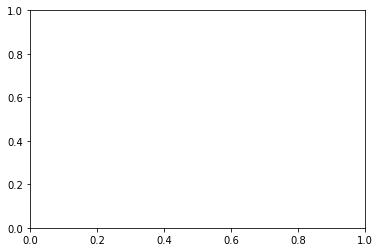

In [97]:
import matplotlib.pyplot as plt

#classification_probs = []
u = [0.1 * x for x in range(1, 10)]

category_metrics = { i : { x : {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0} for x in u} for i in categories }

for i in range(100):#len(test)):
    row = test.iloc[i]
    category = row['categoria']
    title = row['titular']
    vs = classify_with_prob(title)
    
    for cat, v in vs.items():
        test.at[i, f"prob_{cat}"] = v
        
for category in categories:
    records = test.query(f"categoria == '{category}'")
    for index, record in records.iterrows():
        prob = record[f"prob_{category}"]
        for threshold in u:
            if prob >= threshold:
                category_metrics[category][threshold]['tp'] += 1
            else:
                category_metrics[category][threshold]['fn'] += 1
                
    records = test.query(f"categoria != '{category}'")
    for index, record in records.iterrows():
        real_category = record['categoria']
        try:
            prob = record[f"prob_{real_category}"]
        except:
            print(record)
        for threshold in u:
            if prob >= threshold:
                category_metrics[category][threshold]['fp'] += 1
            else:
                category_metrics[category][threshold]['tn'] += 1
    
print(category_metrics)

for c, thresholds in category_metrics.items():
    x = []
    y = []
    for threshold, values in thresholds.items():
        TPR = float(values['tp']) / (values['tp'] + values['fn'])
        FPR = float(values['fp']) / (values['fp'] + values['tn'])
        x.append(FPR)
        y.append(TPR)
    print(x)
    print(y)
    plt.plot(x,y)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()